# Some Beautiful codes are from here

https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

https://www.kaggle.com/code/sikaro/catboost-starter-lb-0-67/edit

I really appreciate for every work

In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore') # 경고 메시지 생략

df=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
test=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
submission=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv')

TARGETS = df.columns[-6:]
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


## Non-overlapping EEG ID TRAIN

In [3]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})

train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp
print(tmp)

            patient_id
eeg_id                
568657           20654
582999           20230
642382            5955
751790           38549
778705           40955
...                ...
4293354003       16610
4293843368       15065
4294455489          56
4294858825        4312
4294958358       25986

[17089 rows x 1 columns]


In [4]:
print(train)

               spec_id     min     max  patient_id
eeg_id                                            
568657       789577333     0.0    16.0       20654
582999      1552638400     0.0    38.0       20230
642382        14960202  1008.0  1032.0        5955
751790       618728447   908.0   908.0       38549
778705        52296320     0.0     0.0       40955
...                ...     ...     ...         ...
4293354003  1188113564     0.0     0.0       16610
4293843368  1549502620     0.0     0.0       15065
4294455489  2105480289     0.0     0.0          56
4294858825   657299228     0.0    12.0        4312
4294958358   260520016  2508.0  2508.0       25986

[17089 rows x 4 columns]


In [5]:
tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
#print(tmp)
#print(train)
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data


tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [6]:
t_copy= train.copy()
t_copy

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333,Other


In [7]:
t_copy.describe()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.708900e+04,1.708900e+04,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000
mean,2.135226e+09,1.080640e+09,401.650711,431.761191,32839.981977,0.152810,0.142456,0.104062,0.065407,0.114851,0.420413
std,1.235712e+09,6.251739e+08,1226.839779,1232.863269,18351.751174,0.331563,0.295541,0.258825,0.187005,0.271425,0.418454
min,5.686570e+05,3.537330e+05,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.062096e+09,5.396648e+08,0.000000,4.000000,17408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.123560e+09,1.073264e+09,0.000000,40.000000,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
75%,3.208261e+09,1.641428e+09,308.000000,346.000000,48272.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.941176
max,4.294958e+09,2.147388e+09,17556.000000,17632.000000,65494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    
    summary['결측값 개수'] = df.isnull().sum().values #결측값 개수 열 추가
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns: #데이터 종류 추가
        if 'id' in col:
            summary.loc[col, '데이터 종류'] = 'id형'
        elif df[col].dtype == object:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif 'vote' in col:
            summary.loc[col, '데이터 종류'] = '투표형'
    summary['첫 번째 값'] = df.loc[0].values #첫째값
    summary['두 번째 값'] = df.loc[1].values #둘째값
    return summary


summary=resumetable(train)
summary = summary.reset_index() #그렇게 구한 서버리를 index 리셋
summary = summary.rename(columns={'index': '피처'}) #피처를 
summary

데이터 세트 형상: (17089, 12)


,피처,데이터 타입,결측값 개수,고윳값 개수,데이터 종류,첫 번째 값,두 번째 값
0,eeg_id,int64,0,17089,id형,568657,582999
1,spec_id,int64,0,11138,id형,789577333,1552638400
2,min,float64,0,1606,연속형,0.0,0.0
3,max,float64,0,1638,연속형,16.0,38.0
4,patient_id,int64,0,1950,id형,20654,20230
5,seizure_vote,float64,0,606,연속형,0.0,0.0
6,lpd_vote,float64,0,595,연속형,0.0,0.857143
7,gpd_vote,float64,0,366,연속형,0.25,0.0
8,lrda_vote,float64,0,487,연속형,0.0,0.071429
9,grda_vote,float64,0,379,연속형,0.166667,0.0


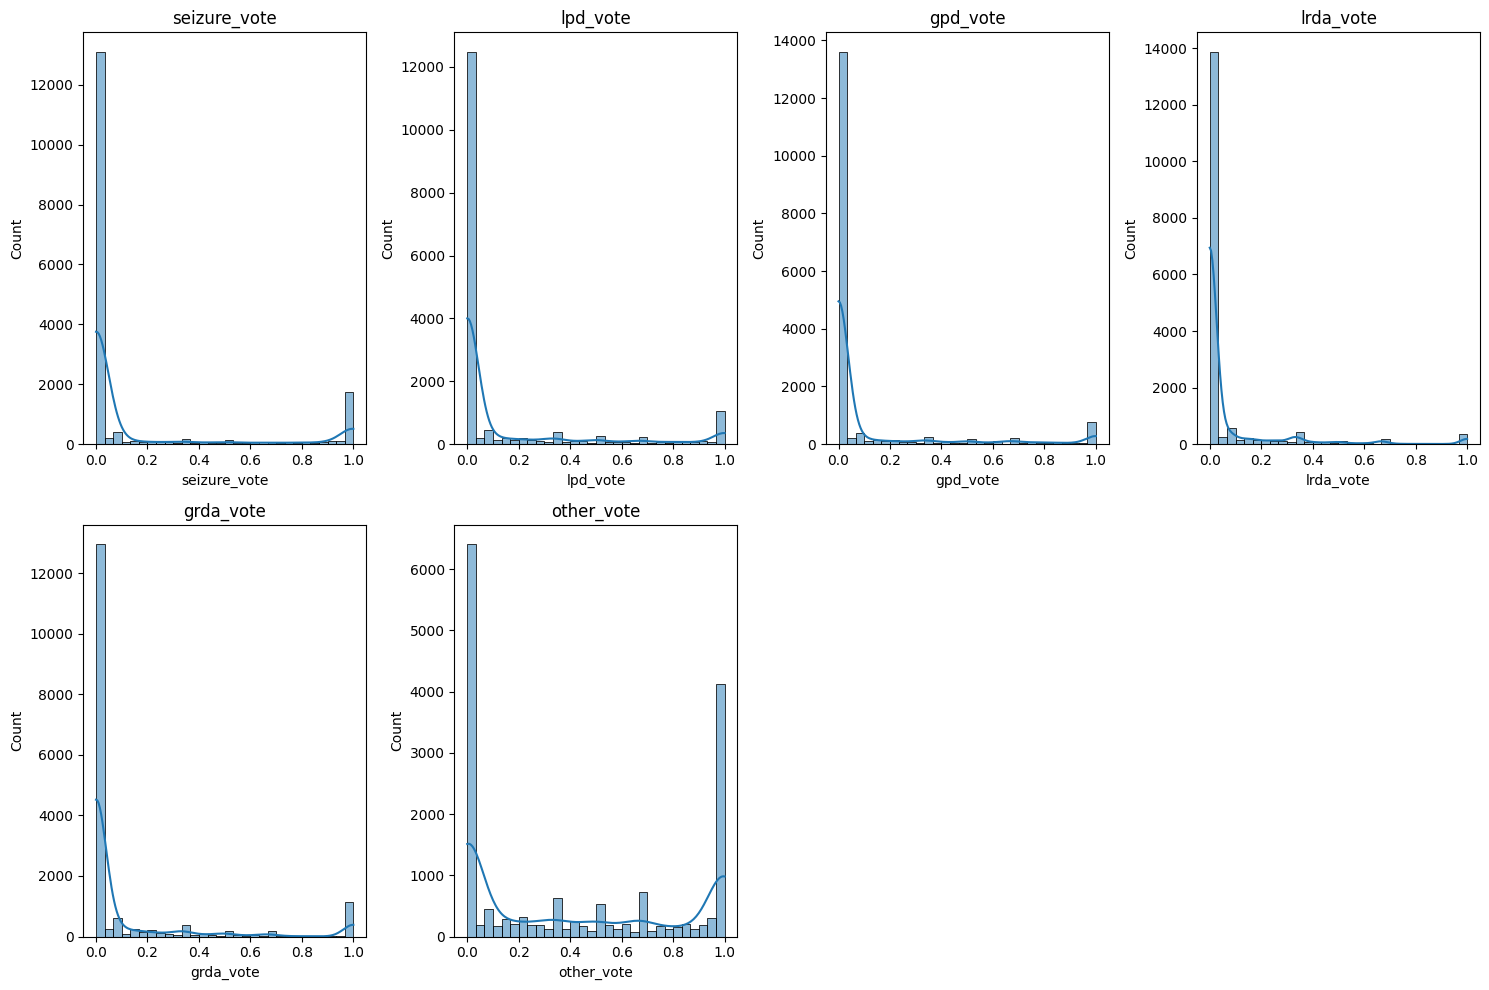

In [9]:
targets = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

plt.figure(figsize=(15, 10))
for i, column in enumerate(targets, 1):
    plt.subplot(2, 4, i)
    sns.histplot(train[column], kde=True, bins=30)
    plt.title(column)
plt.tight_layout()

In [10]:
for feature in targets:
    print('{0}의 와도 {1:0.4f}'.format(feature, train[feature].skew())) #데이터 프레임 내 컬럼을 먼저 입력하고, 그 뒤에 skew나 kurt
    print('{0}의 첨도 {1:0.4f}'.format(feature,train[feature].kurt()))


seizure_vote의 와도 1.9452
seizure_vote의 첨도 2.0266
lpd_vote의 와도 2.0389
lpd_vote의 첨도 2.7467
gpd_vote의 와도 2.5679
gpd_vote의 첨도 5.3327
lrda_vote의 와도 3.5719
lrda_vote의 첨도 13.0794
grda_vote의 와도 2.5111
grda_vote의 첨도 5.0367
other_vote의 와도 0.3276
other_vote의 첨도 -1.5957


In [11]:
spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

In [12]:
all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

In [13]:
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'

In [14]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# FEATURE NAMES
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
FEATURES += [f'eeg_mean_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_min_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_max_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_std_f{x}_10s' for x in range(512)]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs
We are creating 3648 features for 17089 rows... 

In [15]:
row = train.iloc[7]
row

eeg_id            2061593
spec_id         320962633
min                1450.0
max                1450.0
patient_id          23828
seizure_vote          0.0
lpd_vote              0.0
gpd_vote              0.0
lrda_vote             0.0
grda_vote             0.0
other_vote            1.0
target              Other
Name: 7, dtype: object

In [16]:
len(train)

17089

In [17]:
len(FEATURES)

3648

In [18]:
data = np.zeros((len(train),len(FEATURES)))
for k in range(len(train)):
    if k%100==0: print(k,', ',end='')
    row = train.iloc[k]
    r = int( (row['min'] + row['max'])//4 ) 

    # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,:400] = x
    x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,800:1200] = x
    x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
    data[k,1200:1600] = x

    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

train[FEATURES] = data
print(); print('New train shape:',train.shape)

0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 , 13500 , 13600 , 13700 , 13800 , 

In [19]:
# FREE MEMORY
del all_eegs, spectrograms, data
gc.collect()

30138

# CAT BOOST MODEL

In [20]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [21]:
from sklearn.model_selection import KFold, GroupKFold

all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
gkf = GroupKFold(n_splits=5)

In [22]:
t_copy

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333,Other


In [23]:
from sklearn.model_selection import KFold, GroupKFold

all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = CatBoostClassifier(task_type='GPU',
                               loss_function='MultiClass')
    
    train_pool = Pool(
        data = train.loc[train_index,FEATURES],
        label = train.loc[train_index,'target'].map(TARS),
    )
    
    valid_pool = Pool(
        data = train.loc[valid_index,FEATURES],
        label = train.loc[valid_index,'target'].map(TARS),
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    model.save_model(f'CAT_v{1}_f{i}.cat')
    
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.136945
0:	learn: 1.6396718	test: 1.6737097	best: 1.6737097 (0)	total: 364ms	remaining: 6m 4s
100:	learn: 0.7138030	test: 1.0707910	best: 1.0706476 (99)	total: 10.1s	remaining: 1m 29s
200:	learn: 0.5592359	test: 1.0337357	best: 1.0334695 (195)	total: 19.6s	remaining: 1m 18s
300:	learn: 0.4583913	test: 1.0275270	best: 1.0265477 (297)	total: 29s	remaining: 1m 7s
400:	learn: 0.3850699	test: 1.0202451	best: 1.0186940 (381)	total: 38.2s	remaining: 57.1s
500:	learn: 0.3279357	test: 1.0191329	best: 1.0169798 (451)	total: 47.6s	remaining: 47.4s
600:	learn: 0.2789594	test: 1.0212841	best: 1.0169798 (451)	total: 57.1s	remaining: 37.9s
700:	learn: 0.2417184	test: 1.0289869	best: 1.0169798 (451)	total: 1m 6s	remaining: 28.2s
800:	learn: 0.2087914	test: 1.0308966	best: 1.0169798 (451)	total: 1m 15s	remaining: 18.7s
900:	learn: 0.1814822	test: 1.0345071	best: 1.0169798 (451)	tot

In [24]:
all_oof[0:5]

array([[8.54164864e-02, 1.38399229e-01, 2.26718950e-01, 5.17475961e-02,
        1.50044004e-01, 3.47673734e-01],
       [2.67589262e-02, 8.78184895e-03, 5.07318140e-04, 9.37429230e-02,
        1.70750480e-01, 6.99458504e-01],
       [8.23822130e-01, 2.54214770e-02, 1.76694279e-02, 1.87613274e-03,
        7.96039570e-03, 1.23250436e-01],
       [5.20692158e-02, 7.67570880e-03, 9.76535628e-05, 3.91950503e-02,
        6.43161155e-03, 8.94530760e-01],
       [1.39063354e-01, 2.07491598e-01, 4.08163451e-03, 3.15441050e-01,
        2.87310774e-02, 3.05191286e-01]])

In [25]:
len(all_oof)

17089

In [26]:
all_true[0:5]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.]])

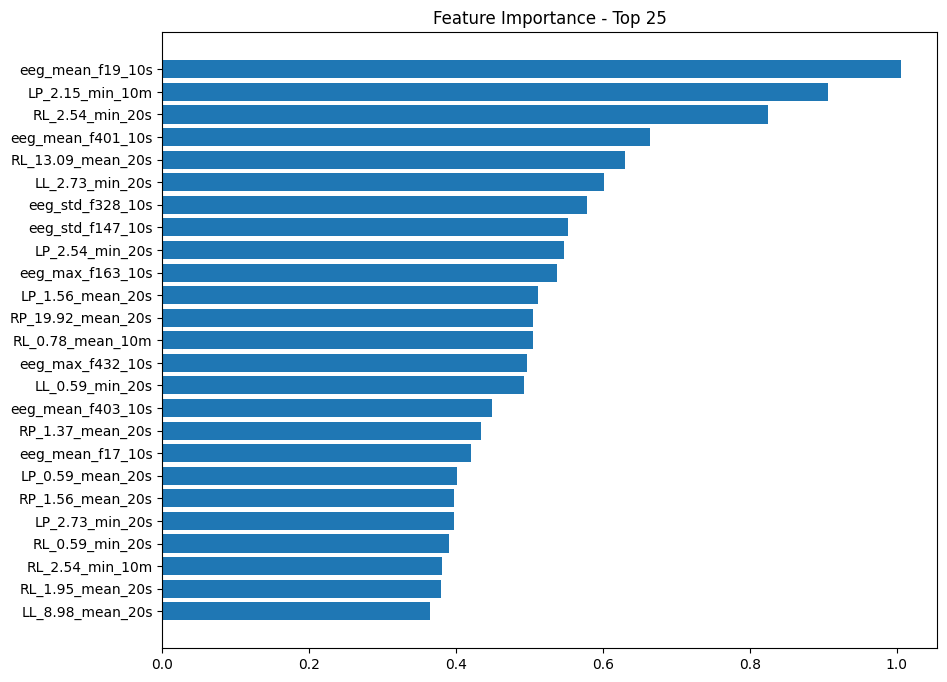

In [27]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.savefig('fig1.png',bbox_inches='tight')
plt.show()

In [28]:
feature_importance[0:5]

array([0.11431696, 0.03351751, 0.        , 0.03803926, 0.        ])

In [29]:
len(sorted_idx)

3648

In [30]:
np.arange(len(sorted_idx))[-TOP:]

array([3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633,
       3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644,
       3645, 3646, 3647])

In [31]:
feature_importance[sorted_idx][-TOP:]  

array([0.36424973, 0.37880933, 0.38001791, 0.39010772, 0.39643271,
       0.39730672, 0.40102671, 0.42070425, 0.43316715, 0.44875696,
       0.4924778 , 0.49596785, 0.50387737, 0.50502569, 0.51085957,
       0.53758586, 0.54737969, 0.5524732 , 0.57873736, 0.60106374,
       0.62980888, 0.66452143, 0.82455308, 0.90555407, 1.00502717])

In [32]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

CV Score KL-Div for CatBoost = 0.7551946998936143


In [33]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [34]:
# CREATE ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 0
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

Converting Test EEG to Spectrograms...



In [35]:
# FEATURE ENGINEER TEST
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
data = np.zeros((len(test),len(FEATURES)))
    
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x
    
    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs2[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

test[FEATURES] = data
print('New test shape',test.shape)

New test shape (1, 3651)


In [36]:
# INFER CATBOOST ON TEST
preds = []

for i in range(5):
    print(i,', ',end='')
    model = CatBoostClassifier(task_type='GPU')
    model.load_model(f'CAT_v{1}_f{i}.cat')
    
    test_pool = Pool(
        data = test[FEATURES]
    )
    
    pred = model.predict_proba(test_pool)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


In [37]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.282869,0.006726,0.000382,0.154421,0.106088,0.449513


In [38]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float64